In [47]:
import json
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [48]:
from imputation import run_comparing, run, imputed_sqr_err, imputed_vals

In [49]:
seed = 42

In [50]:
random_state = np.random.RandomState(seed)
random_generator = np.random.default_rng(seed)

In [51]:
df = pd.read_csv("data/2-test_df.csv", index_col="Unnamed: 0")
df

,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
6364,49.0,0.3,0.88,77.0,68.0,68.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7417,73.0,1.9,0.83,119.0,99.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
982,62.0,1.3,0.85,128.0,109.0,0.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2909,72.0,2.2,1.08,115.0,124.0,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5633,63.0,2.0,1.14,119.0,136.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,74.0,2.6,1.18,111.0,131.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3083,17.0,1.2,1.50,24.0,36.0,145.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,79.0,2.2,1.13,108.0,122.0,2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5443,73.0,2.1,1.11,116.0,130.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
qualitative_cols_f = open('data/qualitative_cols.json', 'r')
categorical_cols_f = open('data/categorical_cols.json', 'r')

In [53]:
complete_vals_df = pd.read_csv("data/5-train_df.csv", index_col="Unnamed: 0") 
remove_vals_df = pd.read_csv("data/5-test_df.csv", index_col="Unnamed: 0") 
missing_vals_idxs = list(remove_vals_df.index)

sel_qual_cols = json.load(qualitative_cols_f)
sel_cat_cols = json.load(categorical_cols_f)

real_df = pd.concat([complete_vals_df, remove_vals_df])

In [54]:
neighbours = 10
iters = 10

## Non Weighted KNN

In [55]:
knn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    knn_imputer = KNNImputer(n_neighbors=neighbours)
    knn_imputed_mat = knn_imputer.fit_transform(curr_df)
    
    knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    knn_imputed_df["{} (real)".format(col)] = real_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

    knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

    knn_imputed_df_map[col] = knn_imputed_df

In [56]:
def col_mse(df : pd.DataFrame, col : str) -> float:
    sqr_err_list = (df[col + " (real)"] - df[col + " (imputed)"]).to_numpy() ** 2
    sqr_err_sum = sqr_err_list.sum()
    mean_sqr_err = sqr_err_sum / sqr_err_list.size
    return mean_sqr_err

In [57]:
for col, knn_imputed_df in knn_imputed_df_map.items():
    display("{} with KNN".format(col))
    display(col_mse(knn_imputed_df, col))
    display(knn_imputed_df)

'age with KNN'

354.6096888504754

,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,age (real),age (imputed)
3196,0.5,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,54.0
1736,1.8,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,58.8
1836,2.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,59.4
4819,2.3,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.0,60.2
4300,2.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,54.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,39.0,59.1
8024,2.6,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,26.0,47.5
4111,2.3,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,62.2
2694,1.9,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,39.3


'T3 with KNN'

0.36365717097320716

,age,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T3 (real),T3 (imputed)
3196,76.0,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.09
1736,57.0,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,2.17
1836,86.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.87
4819,37.0,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.3,2.04
4300,63.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.8,2.15
8024,26.0,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.6,2.08
4111,24.0,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.90
2694,70.0,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.9,1.26


'T4U with KNN'

0.0024506792048401035

,age,T3,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T4U (real),T4U (imputed)
3196,76.0,0.5,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.838
1736,57.0,1.8,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.181
1836,86.0,2.0,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.646
4819,37.0,2.3,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.94,0.925
4300,63.0,2.0,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.94,0.952
8024,26.0,2.6,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.89,0.892
4111,24.0,2.3,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.026
2694,70.0,1.9,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.87,0.881


'FTI with KNN'

484.8367436264754

,age,T3,T4U,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,FTI (real),FTI (imputed)
3196,76.0,0.5,0.85,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,130.6
1736,57.0,1.8,1.38,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,97.2
1836,86.0,2.0,0.62,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,92.0
4819,37.0,2.3,0.94,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,72.0,87.2
4300,63.0,2.0,1.18,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,145.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,97.0,108.3
8024,26.0,2.6,0.89,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,107.0,98.6
4111,24.0,2.3,1.09,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,88.7
2694,70.0,1.9,0.87,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.0,91.5


'TT4 with KNN'

468.60260250648224

,age,T3,T4U,FTI,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TT4 (real),TT4 (imputed)
3196,76.0,0.5,0.85,153.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,127.3
1736,57.0,1.8,1.38,59.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,59.2
1836,86.0,2.0,0.62,126.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,110.3
4819,37.0,2.3,0.94,72.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,80.0
4300,63.0,2.0,1.18,129.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,116.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,91.0,95.0
8024,26.0,2.6,0.89,107.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,95.0,104.2
4111,24.0,2.3,1.09,67.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,76.5
2694,70.0,1.9,0.87,100.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.0,98.8


'TSH with KNN'

280.39092329694387

,age,T3,T4U,FTI,TT4,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TSH (real),TSH (imputed)
3196,76.0,0.5,0.85,153.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,0.6370
1736,57.0,1.8,1.38,59.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,6.8950
1836,86.0,2.0,0.62,126.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,2.2800
4819,37.0,2.3,0.94,72.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.60,4.6505
4300,63.0,2.0,1.18,129.0,152.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,0.8040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.10,1.4350
8024,26.0,2.6,0.89,107.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.10,3.5570
4111,24.0,2.3,1.09,67.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,4.9000
2694,70.0,1.9,0.87,100.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50,1.9260


## KNN Weighted

In [58]:
wknn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
    wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)
    
    wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    wknn_imputed_df["{} (real)".format(col)] = real_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

    wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

    wknn_imputed_df_map[col] = wknn_imputed_df

In [59]:
for col, wknn_imputed_df in wknn_imputed_df_map.items():
    display("{} with WKNN".format(col))
    display(col_mse(wknn_imputed_df, col))
    display(wknn_imputed_df)

'age with WKNN'

357.29938503701385

,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,age (real),age (imputed)
3196,0.5,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,54.417245
1736,1.8,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,58.972865
1836,2.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,60.648271
4819,2.3,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.0,59.591341
4300,2.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,53.957550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,39.0,59.181222
8024,2.6,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,26.0,47.133477
4111,2.3,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,62.649588
2694,1.9,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,32.655057


'T3 with WKNN'

0.36801657401457644

,age,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T3 (real),T3 (imputed)
3196,76.0,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.049020
1736,57.0,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,2.187365
1836,86.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.838117
4819,37.0,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.3,2.030541
4300,63.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.381862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.8,2.199689
8024,26.0,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.6,2.052376
4111,24.0,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.932493
2694,70.0,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.9,1.250763


'T4U with WKNN'

0.0021602875988528873

,age,T3,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T4U (real),T4U (imputed)
3196,76.0,0.5,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.838332
1736,57.0,1.8,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.197201
1836,86.0,2.0,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.641857
4819,37.0,2.3,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.94,0.925287
4300,63.0,2.0,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.175875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.94,0.947983
8024,26.0,2.6,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.89,0.893459
4111,24.0,2.3,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.031139
2694,70.0,1.9,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.87,0.881931


'FTI with WKNN'

478.93866194270845

,age,T3,T4U,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,FTI (real),FTI (imputed)
3196,76.0,0.5,0.85,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,129.044791
1736,57.0,1.8,1.38,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,96.711573
1836,86.0,2.0,0.62,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,94.948841
4819,37.0,2.3,0.94,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,72.0,88.107082
4300,63.0,2.0,1.18,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,143.420438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,97.0,109.171928
8024,26.0,2.6,0.89,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,107.0,98.595374
4111,24.0,2.3,1.09,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,89.976504
2694,70.0,1.9,0.87,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.0,92.758323


'TT4 with WKNN'

467.19375406204625

,age,T3,T4U,FTI,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TT4 (real),TT4 (imputed)
3196,76.0,0.5,0.85,153.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,127.492874
1736,57.0,1.8,1.38,59.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,59.587589
1836,86.0,2.0,0.62,126.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,108.570346
4819,37.0,2.3,0.94,72.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,79.805834
4300,63.0,2.0,1.18,129.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,116.090301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,91.0,94.134755
8024,26.0,2.6,0.89,107.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,95.0,103.531545
4111,24.0,2.3,1.09,67.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,75.996608
2694,70.0,1.9,0.87,100.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.0,98.459582


'TSH with WKNN'

210.3310571941208

,age,T3,T4U,FTI,TT4,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TSH (real),TSH (imputed)
3196,76.0,0.5,0.85,153.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,0.593708
1736,57.0,1.8,1.38,59.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,6.264168
1836,86.0,2.0,0.62,126.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,2.035685
4819,37.0,2.3,0.94,72.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.60,6.167184
4300,63.0,2.0,1.18,129.0,152.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,0.781870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.10,1.591833
8024,26.0,2.6,0.89,107.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.10,3.259902
4111,24.0,2.3,1.09,67.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,12.567437
2694,70.0,1.9,0.87,100.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50,1.947075


## MICE

In [60]:
mice_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
    mice_imputed_mat = mice_imputer.fit_transform(curr_df)
    
    mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

    mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

    mice_imputed_df_map[col] = mice_imputed_df

In [61]:
for col, mice_imputed_df in mice_imputed_df_map.items():
    display("{} with MICE".format(col))
    display(col_mse(mice_imputed_df, col))
    display(mice_imputed_df)

'age with MICE'

302.18508195378973

,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,age (real),age (imputed)
3196,0.5,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,66.191466
1736,1.8,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,52.412442
1836,2.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,56.471119
4819,2.3,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.0,48.716600
4300,2.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,49.727231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,39.0,40.950110
8024,2.6,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,26.0,44.810786
4111,2.3,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,50.105669
2694,1.9,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,52.939898


'T3 with MICE'

0.3527069809714647

,age,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T3 (real),T3 (imputed)
3196,76.0,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.957098
1736,57.0,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,2.126144
1836,86.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.135300
4819,37.0,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.3,1.647871
4300,63.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.326549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.8,2.115022
8024,26.0,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.6,2.239271
4111,24.0,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.922813
2694,70.0,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.9,1.541770


'T4U with MICE'

0.004085771173774405

,age,T3,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T4U (real),T4U (imputed)
3196,76.0,0.5,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.822504
1736,57.0,1.8,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.160293
1836,86.0,2.0,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.651979
4819,37.0,2.3,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.94,0.959519
4300,63.0,2.0,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.204332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.94,0.946560
8024,26.0,2.6,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.89,0.919176
4111,24.0,2.3,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.048079
2694,70.0,1.9,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.87,0.890999


'FTI with MICE'

72.4541399914651

,age,T3,T4U,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,FTI (real),FTI (imputed)
3196,76.0,0.5,0.85,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,147.147812
1736,57.0,1.8,1.38,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,38.380442
1836,86.0,2.0,0.62,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,124.142151
4819,37.0,2.3,0.94,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,72.0,75.605387
4300,63.0,2.0,1.18,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,134.703668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,97.0,97.984719
8024,26.0,2.6,0.89,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,107.0,108.999669
4111,24.0,2.3,1.09,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,63.710361
2694,70.0,1.9,0.87,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.0,102.721513


'TT4 with MICE'

63.083576570641405

,age,T3,T4U,FTI,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TT4 (real),TT4 (imputed)
3196,76.0,0.5,0.85,153.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,131.557552
1736,57.0,1.8,1.38,59.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,102.870463
1836,86.0,2.0,0.62,126.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,82.196165
4819,37.0,2.3,0.94,72.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,67.470799
4300,63.0,2.0,1.18,129.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,144.440330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,91.0,89.415336
8024,26.0,2.6,0.89,107.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,95.0,92.864082
4111,24.0,2.3,1.09,67.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,79.077952
2694,70.0,1.9,0.87,100.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.0,85.560009


'TSH with MICE'

493.0941071560413

,age,T3,T4U,FTI,TT4,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TSH (real),TSH (imputed)
3196,76.0,0.5,0.85,153.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,1.164074
1736,57.0,1.8,1.38,59.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,33.036535
1836,86.0,2.0,0.62,126.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,2.111062
4819,37.0,2.3,0.94,72.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.60,10.557845
4300,63.0,2.0,1.18,129.0,152.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,-0.190872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.10,-1.570196
8024,26.0,2.6,0.89,107.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.10,-2.584429
4111,24.0,2.3,1.09,67.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,18.902031
2694,70.0,1.9,0.87,100.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50,4.114909


## Random Forest MICE

In [62]:
mice_rf_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=random_state,
    ))

    mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)
    
    mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_rf_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

    mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

    mice_rf_imputed_df_map[col] = mice_rf_imputed_df

In [63]:
for col, mice_rf_imputed_df in mice_rf_imputed_df_map.items():
    display("{} with MICE RF".format(col))
    display(col_mse(mice_rf_imputed_df, col))
    display(mice_rf_imputed_df)

'age with MICE RF'

328.0414531812209

,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,age (real),age (imputed)
3196,0.5,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,77.791071
1736,1.8,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,57.418614
1836,2.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0,49.599000
4819,2.3,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.0,46.525354
4300,2.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,54.821953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,1.8,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,39.0,43.790705
8024,2.6,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,26.0,30.152412
4111,2.3,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,60.384842
2694,1.9,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,52.162310


'T3 with MICE RF'

0.4135881671870232

,age,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T3 (real),T3 (imputed)
3196,76.0,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.402601
1736,57.0,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,1.327404
1836,86.0,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.093929
4819,37.0,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.3,1.913804
4300,63.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.306167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.8,2.079430
8024,26.0,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.6,2.141289
4111,24.0,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3,1.820241
2694,70.0,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.9,1.505242


'T4U with MICE RF'

0.0021833722501590673

,age,T3,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,T4U (real),T4U (imputed)
3196,76.0,0.5,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.833750
1736,57.0,1.8,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.330000
1836,86.0,2.0,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.633125
4819,37.0,2.3,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.94,0.981491
4300,63.0,2.0,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.18,1.176611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.94,0.941949
8024,26.0,2.6,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.89,0.876131
4111,24.0,2.3,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.09,1.019429
2694,70.0,1.9,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.87,0.868333


'FTI with MICE RF'

42.43316114218841

,age,T3,T4U,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,FTI (real),FTI (imputed)
3196,76.0,0.5,0.85,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,154.393939
1736,57.0,1.8,1.38,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,60.875000
1836,86.0,2.0,0.62,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,125.392857
4819,37.0,2.3,0.94,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,72.0,69.983333
4300,63.0,2.0,1.18,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,128.932955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,97.0,96.151442
8024,26.0,2.6,0.89,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,107.0,106.921427
4111,24.0,2.3,1.09,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,67.535714
2694,70.0,1.9,0.87,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.0,98.808261


'TT4 with MICE RF'

30.3426365511739

,age,T3,T4U,FTI,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TT4 (real),TT4 (imputed)
3196,76.0,0.5,0.85,153.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,131.296703
1736,57.0,1.8,1.38,59.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,79.750000
1836,86.0,2.0,0.62,126.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,83.747619
4819,37.0,2.3,0.94,72.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,66.788462
4300,63.0,2.0,1.18,129.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,148.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,91.0,88.326574
8024,26.0,2.6,0.89,107.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,95.0,93.661401
4111,24.0,2.3,1.09,67.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,71.450000
2694,70.0,1.9,0.87,100.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.0,87.335288


'TSH with MICE RF'

326.7133431203766

,age,T3,T4U,FTI,TT4,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych,TSH (real),TSH (imputed)
3196,76.0,0.5,0.85,153.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20,1.528552
1736,57.0,1.8,1.38,59.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.10,65.095000
1836,86.0,2.0,0.62,126.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,1.663742
4819,37.0,2.3,0.94,72.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.60,1.709476
4300,63.0,2.0,1.18,129.0,152.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.80,1.085615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.10,1.636884
8024,26.0,2.6,0.89,107.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.10,1.887010
4111,24.0,2.3,1.09,67.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40,3.272700
2694,70.0,1.9,0.87,100.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50,1.606428


In [64]:
from utils.proba_utils import cum_sum_intervals_from_weights, sample_cols, create_nan_vals

In [65]:
import matplotlib.pyplot as plt

In [66]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1
}

cum_sum_intervals, cum_sum_col_map = cum_sum_intervals_from_weights(weight_map)

display(cum_sum_intervals)
display(cum_sum_col_map)

[Interval(0, 0.16666666666666666, closed='left'),
 Interval(0.16666666666666666, 0.3333333333333333, closed='left'),
 Interval(0.3333333333333333, 0.5, closed='left'),
 Interval(0.5, 0.6666666666666666, closed='left'),
 Interval(0.6666666666666666, 0.8333333333333333, closed='left'),
 Interval(0.8333333333333333, 1, closed='both')]

{0: 'age', 1: 'T3', 2: 'T4U', 3: 'TSH', 4: 'TT4', 5: 'FTI'}

In [67]:
picked_cols = sample_cols(remove_vals_df.shape[0], cum_sum_intervals, cum_sum_col_map, random_generator)
missing_vals_df, missing_col_map = create_nan_vals(remove_vals_df, picked_cols)

missing_vals_idxs = list(missing_vals_df.index)

real_df = pd.concat([complete_vals_df, remove_vals_df])
curr_df = pd.concat([complete_vals_df, missing_vals_df])

## KNN

In [68]:
import seaborn as sns

In [69]:
iter_range = []
for i in range(0, 20):
    iter_range.append(i)

In [70]:
mice_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE", "max_iter", "imputer", "max_iters", iter_range,
                               config={
                                   "random_state": random_state
                               }, estimator_config={})

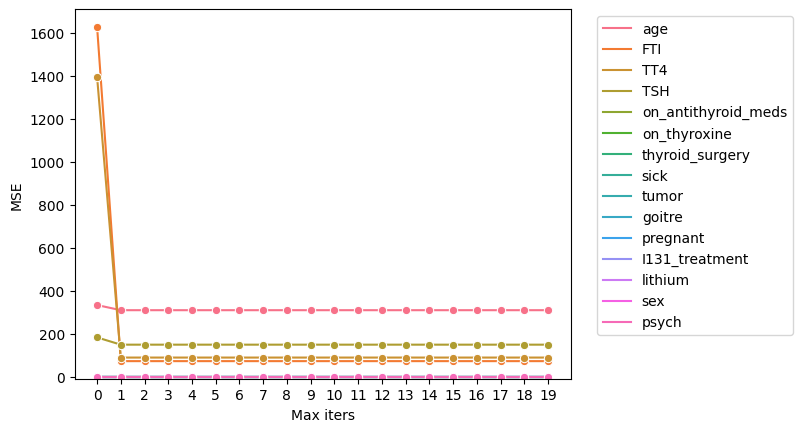

In [71]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] != "T3") & (mice_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

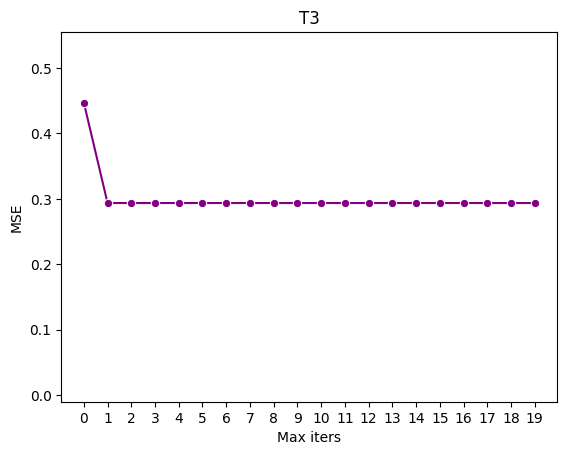

In [72]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

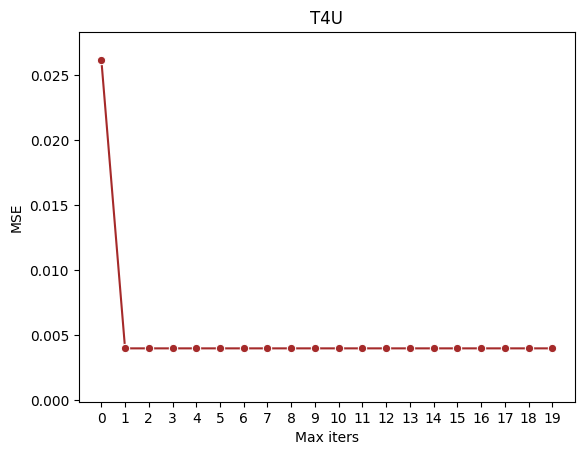

In [73]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [74]:
mice_rf_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_iter", "imputer", "max_iters", iter_range, 
                                  config={
                                      "random_state": random_state
                                      }, estimator_config={
                                          "max_depth": 100,
                                          "random_state": random_state,
                                          "n_estimators": 300,
                                          "max_samples": 0.5,
                                          "bootstrap": True
                                        })

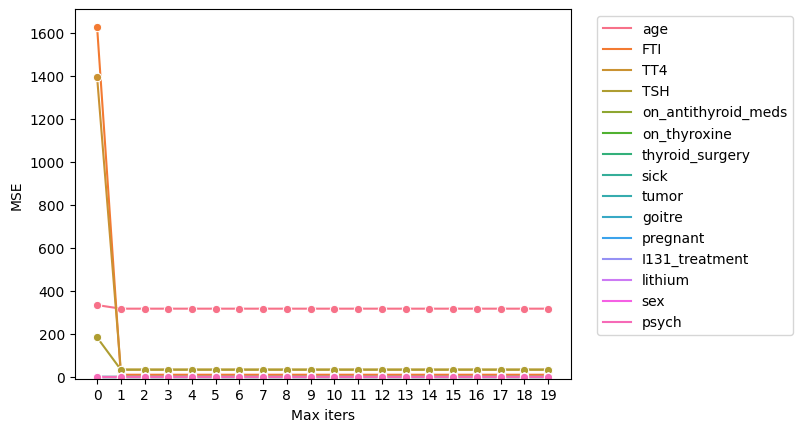

In [75]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] != "T3") & (mice_rf_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

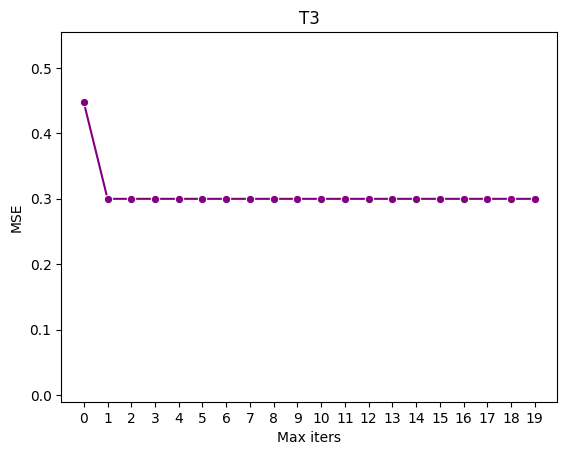

In [76]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

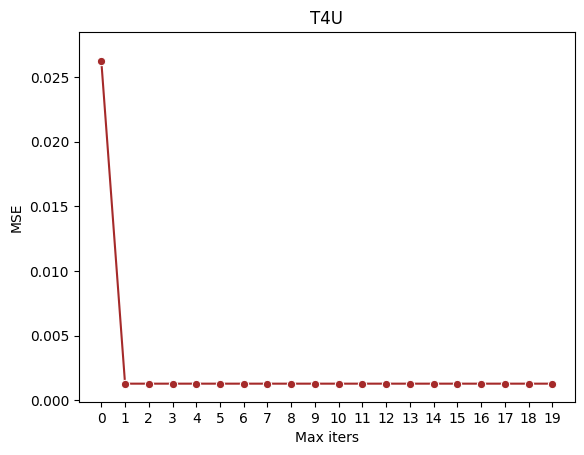

In [77]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [78]:
depths = [1,2,3,4,5,6,7,8,9,10,15,20,30,50,100]
depth_ticks = [1,5,10,15,20,30,50,100]

In [79]:
mice_rf_depth_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_depth", "estimator", "depth", depths, 
                                        config={
                                            "random_state": random_state,
                                            "max_iter": 100
                                        }, estimator_config={
                                            "random_state": random_state,
                                            "n_estimators": 300,
                                            "max_samples": 0.5,
                                            "bootstrap": True
                                        })

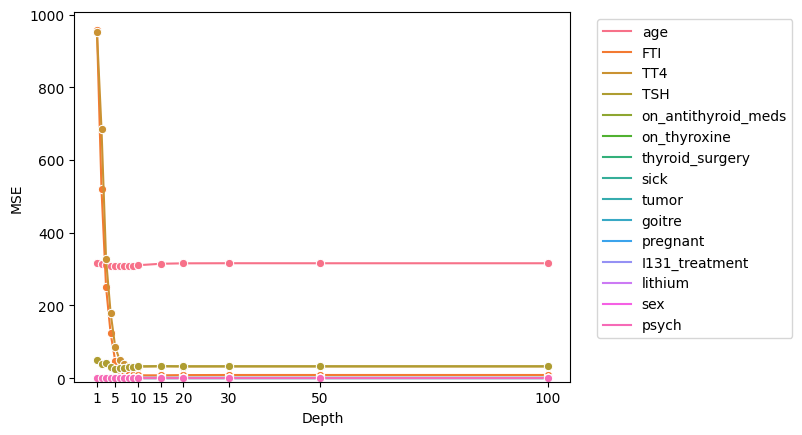

In [80]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] != "T3") & (mice_rf_depth_mse_df["col"] != "T4U")], x="depth", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depth_ticks)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

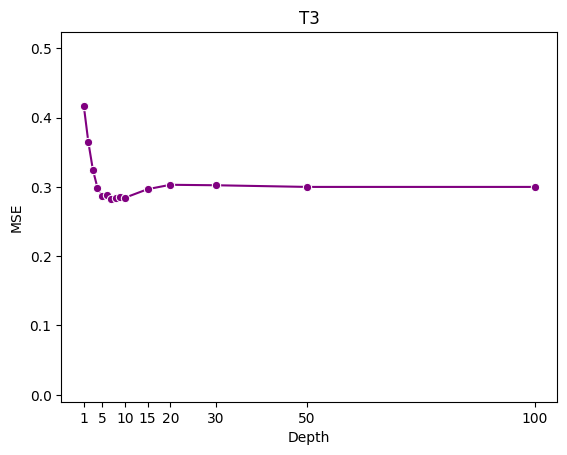

In [81]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T3")], x="depth", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depth_ticks)
#plt.xscale("log")
plt.title("T3")
plt.show()

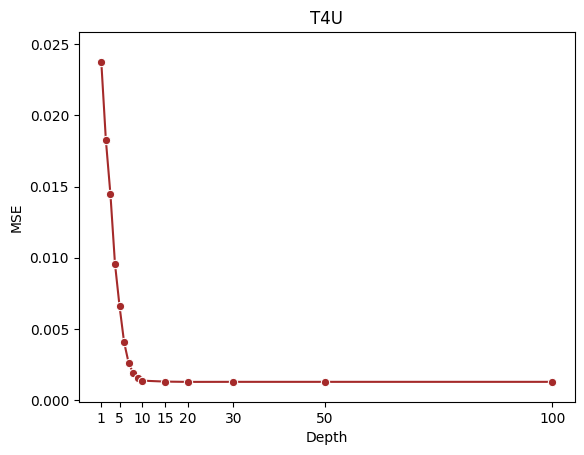

In [82]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T4U")], x="depth", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depth_ticks)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [83]:
estimators = [1, 5, 10, 20, 50, 100]
estimators_ticks = [1, 50, 100]

In [84]:
mice_rf_estimators_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "n_estimators", "estimator", "estimators", estimators, 
                                        config={
                                            "random_state": random_state,
                                            "max_iter": 100
                                        }, estimator_config={
                                            "random_state": random_state,
                                            "max_samples": 0.5,
                                            "bootstrap": True,
                                            "max_depth": 15
                                        })

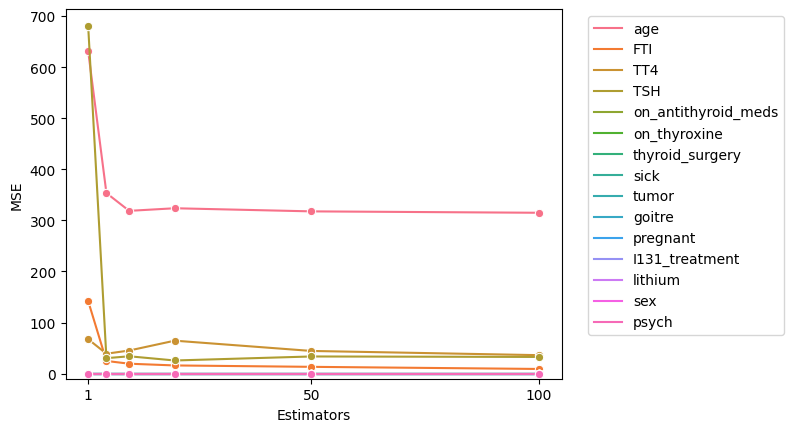

In [85]:
sns.lineplot(data=mice_rf_estimators_mse_df[(mice_rf_estimators_mse_df["col"] != "T3") & (mice_rf_estimators_mse_df["col"] != "T4U")], x="estimators", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Estimators")
plt.xticks(estimators_ticks)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

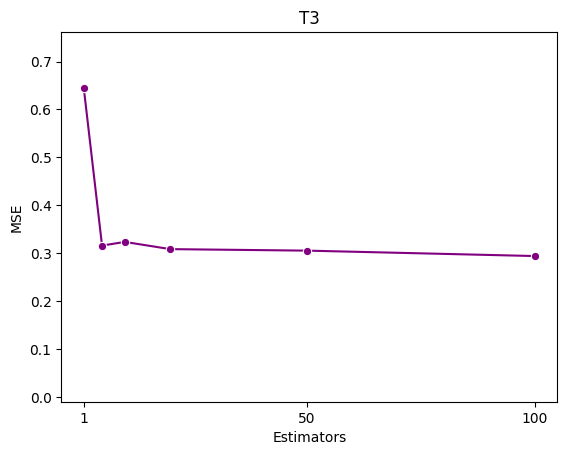

In [86]:
sns.lineplot(data=mice_rf_estimators_mse_df[(mice_rf_estimators_mse_df["col"] == "T3")], x="estimators", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Estimators")
plt.xticks(estimators_ticks)
#plt.xscale("log")
plt.title("T3")
plt.show()

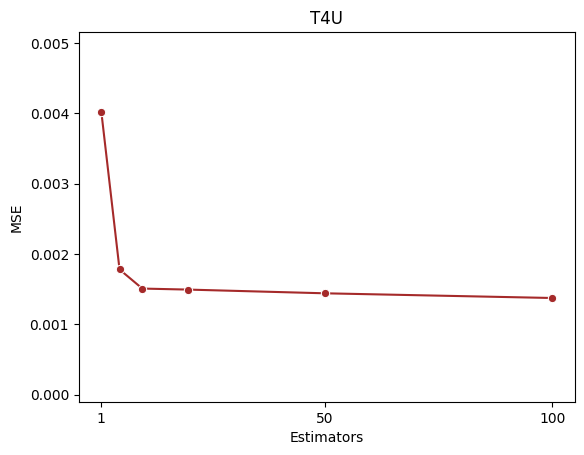

In [87]:
sns.lineplot(data=mice_rf_estimators_mse_df[(mice_rf_estimators_mse_df["col"] == "T4U")], x="estimators", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Estimators")
plt.xticks(estimators_ticks)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [88]:
samples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [89]:
mice_rf_samples_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_samples", "estimator", "samples", samples, 
                                        config={
                                            "random_state": random_state,
                                            "max_iter": 100
                                        }, estimator_config={
                                            "random_state": random_state,
                                            "n_estimators": 300,
                                            "bootstrap": True,
                                            "max_depth": 15
                                        })

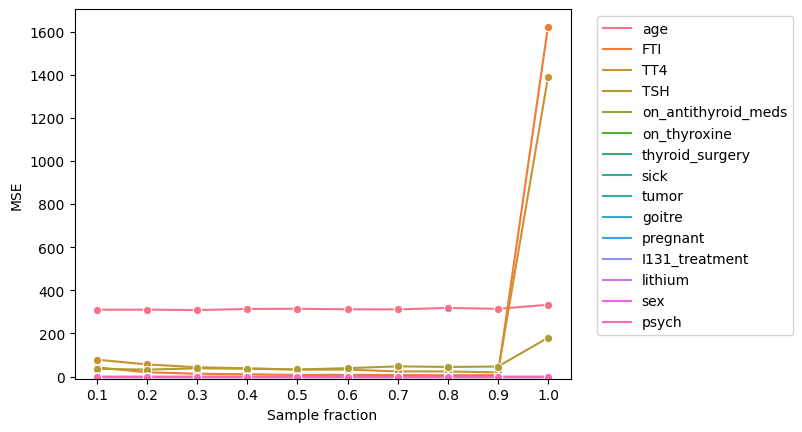

In [90]:
sns.lineplot(data=mice_rf_samples_mse_df[(mice_rf_samples_mse_df["col"] != "T3") & (mice_rf_samples_mse_df["col"] != "T4U")], x="samples", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Sample fraction")
plt.xticks(samples)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

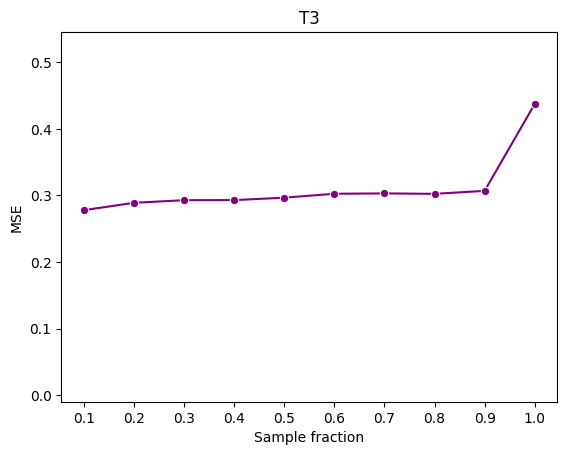

In [91]:
sns.lineplot(data=mice_rf_samples_mse_df[(mice_rf_samples_mse_df["col"] == "T3")], x="samples", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Sample fraction")
plt.xticks(samples)
#plt.xscale("log")
plt.title("T3")
plt.show()

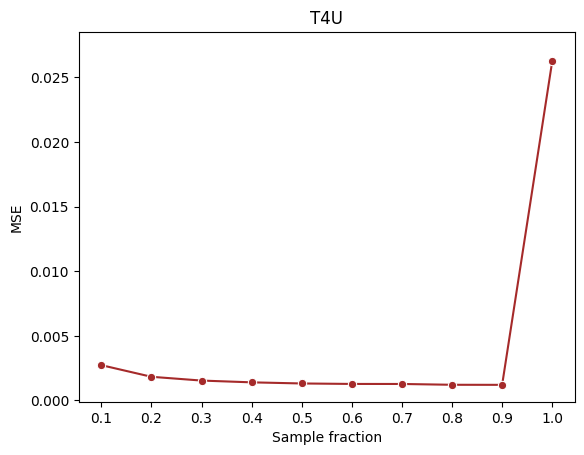

In [92]:
sns.lineplot(data=mice_rf_samples_mse_df[(mice_rf_samples_mse_df["col"] == "T4U")], x="samples", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Sample fraction")
plt.xticks(samples)
#plt.xscale("log")
plt.title("T4U")
plt.show()